<h2>Graph Neural Networks From Scratch</h2><br>

A gentle introduction to Graph Neural Networks(GNNs). We will use an interaction network (a kind of GNN) for the task of predicting the trajectory of planets in a solar system.


Attributions:<br>
Physics Engine: https://github.com/jaesik817/Interaction-networks_tensorflow/blob/master/physics_engine.py<br>
Original Paper: https://arxiv.org/pdf/1612.00222v1.pdf<br>
On Graph Neural Networks: https://arxiv.org/abs/1806.01261 (How this architecture can be extended for link prediction, graph and subgraph prediction tasks)<br>



In [3]:
import os
import random
import time

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from Physics_Engine import gen

from IPython.display import clear_output
from tqdm import tqdm
import matplotlib.pyplot as plt
import pygame
import sys


<h2>Generating a dataset </h2>

The gen function generates a solar system:<br>

gen(num_planets, orbit, num_points)<br>
num_planets: Number of planets in the solar system<br>
orbit: If set to true, has one planet with a lot of mass that acts like a sun<br>
num_points: Amount of data points/length of the trajectory <br>

In [4]:
num_planets  = 3 
num_node_features = 5 

num_edges  = num_planets * (num_planets - 1) 
num_edge_features = 1


data = gen(num_planets, True, 1000)


class planet:
    def __init__(self, name, mass, pos_x, pos_y):
        # assertions about horizon of experiment
        self.name = name
        self.radius = max(10, int(mass/2.5))
        self.mass = mass
        self.pos_x = pos_x
        self.pos_y = pos_y
        self.color = (random.randrange(0,255), random.randrange(0,255), random.randrange(0,255))
    def get_pos(self, timestamp):
        return (int(self.pos_x[timestamp]), int(self.pos_y[timestamp]))
    
planets = []

for p in range(data.shape[1]):
    mass = data[0][p][0]
    pos_x = data[:,p,1]
    pos_y = data[:,p,2]
    planets.append(planet(chr(ord('a')+p), mass, pos_x, pos_y))

 

<h2>Basic Statistics</h2>

Each Planet is described by 5 features: [Mass, Pos_X, Pos_Y, Speed_X, Speed_Y]<br>
The task is to predict the next [Pos_X, Pos_Y]<br>
Imagine you can run this simulator unlimited times to generate unlimited training data

In [5]:

print('Number of Planets:', num_planets)
print('Number of Features:', num_node_features)
print('Dataset shape:', data.shape)

print()
print('Planet weights:', data[0,:,0])

print()
print('Features: [Mass, Pos_X, Pos_Y, Speed_X, Speed_Y]')
print('Features example:',data[10,1,:])

avg_dist = np.mean(np.abs(data[1:999,2,1] - data[0:998,2,1])) + np.mean(np.abs(data[1:999,2,2] - data[0:998,2,2]))


Number of Planets: 3
Number of Features: 5
Dataset shape: (1000, 3, 5)

Planet weights: [100.           5.81178715   1.32853627]

Features: [Mass, Pos_X, Pos_Y, Speed_X, Speed_Y]
Features example: [   5.81178715  -37.48360254   33.78708085 -108.87959659 -168.42588237]


<h2>Visualization</h2>

In [13]:
pygame.init()

screen = pygame.display.set_mode((800,800))

pygame.display.set_caption('Mock Solar System')

fps = pygame.time.Clock()

paused = False


def render(timestep):

    screen.fill((0,0,0))
    
    for planet in planets:
        pos = planet.get_pos(timestep)
        pygame.draw.circle(screen, planet.color, (pos[0]+250, pos[1]+250), planet.radius, 0)

    pygame.display.update()

    fps.tick(60)


timestep = 0


while True:

    pygame.event.get()
        
    if timestep > 500:
        pygame.quit()
        sys.exit
        break


    render(timestep)
    timestep+=1

<h2> A simple NN architecture</h2>

In [6]:
# Define network dimensions
n_input_dim = data.shape[1] * data.shape[2]
# Layer size
n_hidden = 32 
n_output = 6 
learning_rate = 0.005

# Network
net = nn.Sequential(
    nn.Linear(n_input_dim, n_hidden),
    nn.ReLU(),
    nn.Linear(n_hidden, n_output))

loss_func = nn.MSELoss()

optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    
print(net)

Sequential(
  (0): Linear(in_features=15, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=6, bias=True)
)


<h2> Train a simple NN model</h2>

The caveat being that the train and test solar systems are different

In [7]:
train_losses = []
test_losses = []
train_accuracy = []
epochs = 1000
for i in range(epochs):
    # Every epoch, a 3-planet solar system is generated
    
    data = gen(num_planets, True, 100)

    train_X = torch.FloatTensor(data[0:80].reshape(80,-1))
    test_X = torch.FloatTensor(data[80:-1].reshape(19,-1))

    train_y = torch.FloatTensor(data[1:81,:,:2].reshape(80,-1))
    test_y = torch.FloatTensor(data[81:,:,:2].reshape(19,-1))
    
    # Train

    y_hat = net(train_X)
    loss = loss_func(y_hat, train_y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    # Test
    
    y_hat = net(test_X)
    test_loss = loss_func(y_hat, test_y)
    optimizer.zero_grad()
    
    train_losses.append(loss.item())
    test_losses.append(test_loss.item())
    
    
    
    print('Epoch:', i, 'Train RMSE:', round(np.sqrt(loss.item()),3), 'Test RMSE', round(np.sqrt(test_loss.item()), 3))


Epoch: 0 Train RMSE: 38.607 Test RMSE 33.882
Epoch: 1 Train RMSE: 56.189 Test RMSE 46.244
Epoch: 2 Train RMSE: 41.685 Test RMSE 42.315
Epoch: 3 Train RMSE: 40.179 Test RMSE 72.271
Epoch: 4 Train RMSE: 41.91 Test RMSE 42.039
Epoch: 5 Train RMSE: 30.916 Test RMSE 22.739
Epoch: 6 Train RMSE: 41.596 Test RMSE 34.508
Epoch: 7 Train RMSE: 40.192 Test RMSE 30.579
Epoch: 8 Train RMSE: 36.37 Test RMSE 28.739
Epoch: 9 Train RMSE: 26.861 Test RMSE 20.272
Epoch: 10 Train RMSE: 36.005 Test RMSE 30.579
Epoch: 11 Train RMSE: 43.622 Test RMSE 37.111
Epoch: 12 Train RMSE: 37.606 Test RMSE 33.686
Epoch: 13 Train RMSE: 40.686 Test RMSE 33.131
Epoch: 14 Train RMSE: 59.869 Test RMSE 23.153
Epoch: 15 Train RMSE: 17.417 Test RMSE 68.534
Epoch: 16 Train RMSE: 43.515 Test RMSE 48.62
Epoch: 17 Train RMSE: 36.913 Test RMSE 72.805
Epoch: 18 Train RMSE: 37.727 Test RMSE 65.11
Epoch: 19 Train RMSE: 41.021 Test RMSE 43.483
Epoch: 20 Train RMSE: 34.724 Test RMSE 33.941
Epoch: 21 Train RMSE: 33.435 Test RMSE 22.99
Epo

KeyboardInterrupt: 

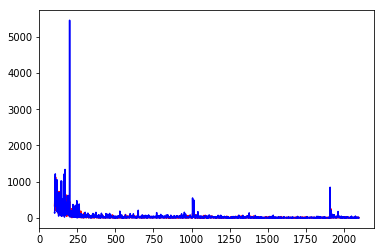

In [9]:
%matplotlib inline

# Plotting the loss

t = range(0,len(train_losses))[100:]
a = train_losses[100:]
b = test_losses[100:]


plt.plot(t, a, 'r') # plotting t, a separately 
plt.plot(t, b, 'b') # plotting t, b separately 
plt.show()

In [8]:
# Helper function to get a batch of data for the next part


def get_batch(train = True):
    
    batch_size = 99
    
    num_planets  = random.randrange(1,6)
    
    if train:
        num_planets = 3
    
    num_node_features = 5 
    num_edges  = num_planets * (num_planets - 1) 
    num_edge_features = 1


    data = gen(num_planets, True, 100)
    
    X = data[0:99]
    y = data[1:100,:,:2]

    edge_list = []

    for i in range(num_planets):
        for j in range(num_planets):
            if i!=j:
                edge_list.append((i,j))
                


    edge_out = np.zeros((batch_size, num_edges, num_planets), dtype=float);
    edge_in = np.zeros((batch_size, num_edges, num_planets), dtype=float);
    edge_features = Variable(torch.FloatTensor(np.zeros((batch_size, num_edges, num_edge_features))))


    row = 0
    for edge in edge_list:
        edge_out[0,row,edge[0]] = 1
        edge_in[0,row,edge[1]] = 1

        row+=1


    edge_out = Variable(torch.FloatTensor(edge_out))
    edge_in = Variable(torch.FloatTensor(edge_in))
         

    data = Variable(torch.FloatTensor(X))
    labels = Variable(torch.FloatTensor(y.reshape(-1,2)))
    
    return data, edge_out, edge_in, edge_features, labels



<h2>Graph Neural Network</h2>

Motivation behind a graph neural network:<br>

1) The solution should explicitly learn interactions between objects <br>
2) The solution should treat individual nodes and edges as a separate unit (Instead of concatenating all the features in our vanilla NN implementation. <br>
3) The solution should generalize beyond different systems and different number of planets.<br>
4) The solution should be invariant to permutation (No fixed ordering of planets like the vanilla NN).

In [9]:
class graph_NN(nn.Module):
    def __init__(self, num_node_features, num_edge_features, hidden_dim, embedding_dim, output_dim):
        super(graph_NN, self).__init__()
        
        self.edge_NN = nn.Sequential(nn.Linear(2 * num_node_features + num_edge_features, hidden_dim), 
                                     nn.ReLU(), 
                                     nn.Linear(hidden_dim, embedding_dim))
        
        self.node_NN = nn.Sequential(nn.Linear(num_node_features + embedding_dim, hidden_dim),
                                     nn.ReLU(),
                                     nn.Linear(hidden_dim, output_dim),
                                    )
        print('edge_NN:', self.edge_NN)
        print('node_NN:', self.node_NN)
    
    def forward(self, data, edge_out, edge_in, edge_features):
        
        first_vertex_data   = edge_out.bmm(data)
        second_vertex_data = edge_in.bmm(data)
        
        edge_embeddings = self.edge_NN(torch.cat([first_vertex_data, second_vertex_data, edge_features], 2))
        
        aggregated_edge_embeddings = edge_in.permute(0,2,1).bmm(edge_embeddings)
        
        predicted = self.node_NN(torch.cat([data,aggregated_edge_embeddings], 2).view(-1, num_node_features + embedding_dim))
        
        return predicted

In [13]:
n_epoch = 1000
lr = 0.005
hidden_dim = 16
embedding_dim = 8
output_dim = 2
num_node_features = 5
num_edge_features = 1

graph_NN_instance = graph_NN(num_node_features, num_edge_features,  hidden_dim, embedding_dim, output_dim)
optimizer = optim.Adam(graph_NN_instance.parameters(),  lr=lr)
criterion = nn.MSELoss()

edge_NN: Sequential(
  (0): Linear(in_features=11, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=8, bias=True)
)
node_NN: Sequential(
  (0): Linear(in_features=13, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=2, bias=True)
)


<h2>Train the Graph Neural Network!</h2>

At training time, we use a 3 planet solar system. At test time, the solar system is randomly generated to have 1 to 6 planets!

In [14]:
losses = []

for epoch in range(1000):
    data, edge_out, edge_in, edge_features, labels = get_batch()
    
    predicted = graph_NN_instance(data, edge_out, edge_in, edge_features)
    
    loss = criterion(predicted, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(np.sqrt(loss.data))
    
    data_test, edge_out, edge_in, edge_features, labels = get_batch(False)    
    predicted = graph_NN_instance(data_test, edge_out, edge_in, edge_features)
    test_loss = criterion(predicted, labels)

    print('Epoch:', epoch, 'Test RMSE:', np.sqrt(test_loss.data),'Test Planets:', data_test.shape[1])

        
        


Epoch: 0 Test RMSE: tensor(62.5799) Test Planets: 1
Epoch: 1 Test RMSE: tensor(62.0537) Test Planets: 1
Epoch: 2 Test RMSE: tensor(43.1503) Test Planets: 5
Epoch: 3 Test RMSE: tensor(45.4547) Test Planets: 2
Epoch: 4 Test RMSE: tensor(41.8911) Test Planets: 5
Epoch: 5 Test RMSE: tensor(42.8199) Test Planets: 4
Epoch: 6 Test RMSE: tensor(44.6206) Test Planets: 2
Epoch: 7 Test RMSE: tensor(41.0803) Test Planets: 5
Epoch: 8 Test RMSE: tensor(35.4738) Test Planets: 5
Epoch: 9 Test RMSE: tensor(40.8927) Test Planets: 2
Epoch: 10 Test RMSE: tensor(43.4359) Test Planets: 2
Epoch: 11 Test RMSE: tensor(38.5295) Test Planets: 4
Epoch: 12 Test RMSE: tensor(38.7150) Test Planets: 3
Epoch: 13 Test RMSE: tensor(37.5524) Test Planets: 3
Epoch: 14 Test RMSE: tensor(32.8031) Test Planets: 4
Epoch: 15 Test RMSE: tensor(33.1974) Test Planets: 4
Epoch: 16 Test RMSE: tensor(41.9383) Test Planets: 3
Epoch: 17 Test RMSE: tensor(49.0340) Test Planets: 2
Epoch: 18 Test RMSE: tensor(43.8386) Test Planets: 4
Epo

Epoch: 308 Test RMSE: tensor(4.9413) Test Planets: 4
Epoch: 309 Test RMSE: tensor(3.4828) Test Planets: 4
Epoch: 310 Test RMSE: tensor(5.7830) Test Planets: 4
Epoch: 311 Test RMSE: tensor(0.4860) Test Planets: 1
Epoch: 312 Test RMSE: tensor(0.5140) Test Planets: 1
Epoch: 313 Test RMSE: tensor(3.7829) Test Planets: 5
Epoch: 314 Test RMSE: tensor(2.2471) Test Planets: 2
Epoch: 315 Test RMSE: tensor(0.6846) Test Planets: 1
Epoch: 316 Test RMSE: tensor(4.1769) Test Planets: 5
Epoch: 317 Test RMSE: tensor(5.6062) Test Planets: 2
Epoch: 318 Test RMSE: tensor(3.0777) Test Planets: 3
Epoch: 319 Test RMSE: tensor(0.7626) Test Planets: 1
Epoch: 320 Test RMSE: tensor(2.0893) Test Planets: 2
Epoch: 321 Test RMSE: tensor(8.9126) Test Planets: 5
Epoch: 322 Test RMSE: tensor(3.6052) Test Planets: 4
Epoch: 323 Test RMSE: tensor(0.3247) Test Planets: 1
Epoch: 324 Test RMSE: tensor(3.5378) Test Planets: 3
Epoch: 325 Test RMSE: tensor(4.2745) Test Planets: 4
Epoch: 326 Test RMSE: tensor(2.6213) Test Plan

Epoch: 616 Test RMSE: tensor(3.3826) Test Planets: 3
Epoch: 617 Test RMSE: tensor(0.3354) Test Planets: 1
Epoch: 618 Test RMSE: tensor(0.3749) Test Planets: 1
Epoch: 619 Test RMSE: tensor(0.5346) Test Planets: 1
Epoch: 620 Test RMSE: tensor(2.0302) Test Planets: 2
Epoch: 621 Test RMSE: tensor(1.4671) Test Planets: 2
Epoch: 622 Test RMSE: tensor(7.3465) Test Planets: 3
Epoch: 623 Test RMSE: tensor(2.2762) Test Planets: 3
Epoch: 624 Test RMSE: tensor(3.9643) Test Planets: 4
Epoch: 625 Test RMSE: tensor(1.3373) Test Planets: 1
Epoch: 626 Test RMSE: tensor(2.4412) Test Planets: 5
Epoch: 627 Test RMSE: tensor(1.7667) Test Planets: 3
Epoch: 628 Test RMSE: tensor(3.2696) Test Planets: 3
Epoch: 629 Test RMSE: tensor(1.0369) Test Planets: 1
Epoch: 630 Test RMSE: tensor(5.0009) Test Planets: 3
Epoch: 631 Test RMSE: tensor(4.9640) Test Planets: 3
Epoch: 632 Test RMSE: tensor(3.0092) Test Planets: 4
Epoch: 633 Test RMSE: tensor(2.5496) Test Planets: 4
Epoch: 634 Test RMSE: tensor(1.4481) Test Plan

Epoch: 924 Test RMSE: tensor(0.6303) Test Planets: 3
Epoch: 925 Test RMSE: tensor(1.1029) Test Planets: 3
Epoch: 926 Test RMSE: tensor(2.2307) Test Planets: 5
Epoch: 927 Test RMSE: tensor(1.2691) Test Planets: 4
Epoch: 928 Test RMSE: tensor(1.2117) Test Planets: 5
Epoch: 929 Test RMSE: tensor(0.9848) Test Planets: 2
Epoch: 930 Test RMSE: tensor(0.5871) Test Planets: 1
Epoch: 931 Test RMSE: tensor(0.7305) Test Planets: 2
Epoch: 932 Test RMSE: tensor(1.3732) Test Planets: 5
Epoch: 933 Test RMSE: tensor(1.0822) Test Planets: 4
Epoch: 934 Test RMSE: tensor(1.7563) Test Planets: 5
Epoch: 935 Test RMSE: tensor(1.5334) Test Planets: 5
Epoch: 936 Test RMSE: tensor(1.2399) Test Planets: 3
Epoch: 937 Test RMSE: tensor(1.4844) Test Planets: 4
Epoch: 938 Test RMSE: tensor(0.8578) Test Planets: 5
Epoch: 939 Test RMSE: tensor(0.2322) Test Planets: 1
Epoch: 940 Test RMSE: tensor(0.9557) Test Planets: 4
Epoch: 941 Test RMSE: tensor(1.5905) Test Planets: 5
Epoch: 942 Test RMSE: tensor(0.9775) Test Plan